This is an exploratory CNN with the objective of denoising documents. The data is available on Kaggle. This was an interesting assignment and will be meaningful to the real world (Cleaning up scanned documents and images of faxes.) <br><br>
Kaggle Competition: <br>
https://www.kaggle.com/c/denoising-dirty-documents

In [49]:
#Import Dependencies
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from PIL import Image
from time import time
import os
import sys
import pickle as pkl
from keras.models import Sequential,Model, load_model
from keras.layers import Dropout, Flatten,Dense, GlobalAveragePooling2D, Input 
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator 
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.utils import plot_model
import seaborn as sns
%matplotlib inline
import unittest
from sklearn.model_selection import train_test_split

# Data Processing

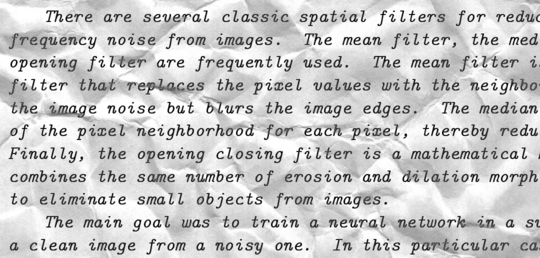

In [2]:
train_images = os.listdir('data/train')
test_images = os.listdir('data/test')
clean_images = os.listdir('data/train_cleaned')
Image.open('data/train/' + train_images[0])

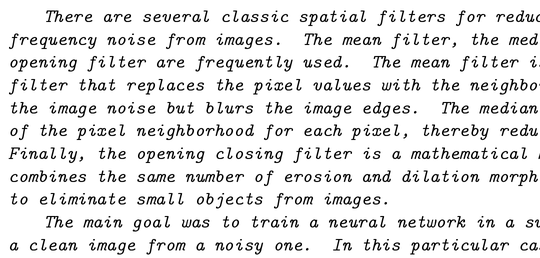

In [3]:
Image.open('data/train_cleaned/' + train_images[0])

In [4]:
test_image = Image.open('data/train/' + train_images[10])
test_image.size

(540, 258)

(540, 258) looks like a common size for images in this dataset. Will set as default size.

In [5]:
def set_common_size(img_link, std_size = (256, 540)):
    '''Function will take in the argument of a link to an image and return the image 
    with the standard size.'''
    img = Image.open(img_link)
    img = image.img_to_array(img)
    img = np.resize(img, std_size)
    return img / 255
set_common_size('data/train/' + train_images[10])

array([[0.9137255 , 0.91764706, 0.9254902 , ..., 0.90588236, 0.90588236,
        0.9137255 ],
       [0.9098039 , 0.8980392 , 0.8980392 , ..., 0.9254902 , 0.92156863,
        0.9137255 ],
       [0.8666667 , 0.87058824, 0.88235295, ..., 0.9137255 , 0.92156863,
        0.9254902 ],
       ...,
       [0.84705883, 0.8352941 , 0.8509804 , ..., 0.92941177, 0.92941177,
        0.92941177],
       [0.87058824, 0.85882354, 0.84705883, ..., 0.95686275, 0.9490196 ,
        0.92156863],
       [0.8627451 , 0.85882354, 0.8509804 , ..., 0.93333334, 0.9529412 ,
        0.9372549 ]], dtype=float32)

In [6]:
class TestFileSize(unittest.TestCase):
    def test_file_size(self):
        file = set_common_size('data/train/' + train_images[10])
        self.assertEqual(file.size, (540, 256))

In [7]:
train_data = []
test_data = []
cleaned_data = []
for img in train_images:
    img_file = set_common_size('data/train/' + img)
    train_data.append(img_file)
for img in test_images:
    img_file = set_common_size('data/test/' + img)
    test_data.append(img_file)
for img in clean_images:
    img_file = set_common_size('data/train_cleaned/' + img)
    cleaned_data.append(img_file)
train_data = np.asarray(train_data)
test_data = np.asarray(test_data)
cleaned_data = np.asarray(cleaned_data)

In [8]:
train_data[0]

array([[0.9372549 , 0.9137255 , 0.90588236, ..., 0.6627451 , 0.6901961 ,
        0.7294118 ],
       [0.9098039 , 0.9137255 , 0.90588236, ..., 0.5882353 , 0.627451  ,
        0.7058824 ],
       [0.92156863, 0.93333334, 0.9254902 , ..., 0.6156863 , 0.5921569 ,
        0.6039216 ],
       ...,
       [0.8235294 , 0.8156863 , 0.81960785, ..., 0.7607843 , 0.7529412 ,
        0.7529412 ],
       [0.8235294 , 0.8235294 , 0.81960785, ..., 0.7529412 , 0.73333335,
        0.7411765 ],
       [0.8156863 , 0.8117647 , 0.8235294 , ..., 0.75686276, 0.74509805,
        0.76862746]], dtype=float32)

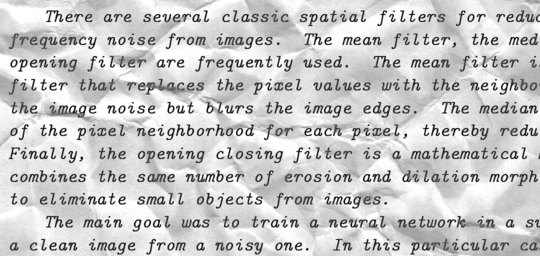

In [9]:
img = np.array((train_data[0] * 255), dtype=np.uint8)
Image.fromarray(img)

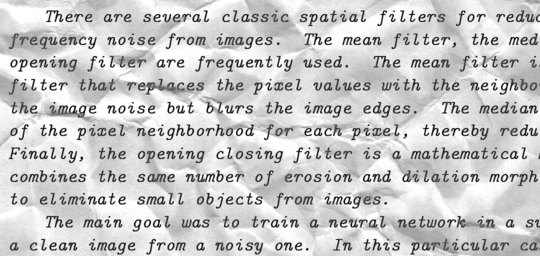

In [10]:
def return_as_image(np_array):
    return Image.fromarray(np.array((np_array * 255), dtype=np.uint8))
return_as_image(train_data[0])

### Objective
An convolutional autoencoder will compress an image and then uncompress the image. The goal of this project is to remove the noise observed above (crumpled lines). 
<img src='assets/convolutional_autoencoder.png' width=500px>

In [11]:
x_train, x_test, y_train, y_test = train_test_split(train_data, cleaned_data, test_size=0.1, random_state=42)

In [12]:
len(x_train), len(x_test)

(129, 15)

In [13]:
x_train = x_train.reshape(x_train.shape[0], 256, 540, 1)
x_test = x_test.reshape(x_test.shape[0], 256, 540, 1)
y_train = y_train.reshape(y_train.shape[0], 256, 540, 1)
y_test = y_test.reshape(y_test.shape[0], 256, 540, 1)

In [14]:
x_train[0].shape

(256, 540, 1)

In [15]:
input_shape = x_train[0].shape
input_layer = Input(input_shape)

In [16]:
#Layer 1
model = Sequential()
model.add(Conv2D(64, 3, activation='relu', padding='same', input_shape=input_shape))
model.add(MaxPooling2D(2))
model.add(Dropout(0.4))
#Layer 2
model.add(Conv2D(128, 3, activation='relu', padding='same'))
model.add(MaxPooling2D(2))
model.add(Dropout(0.4))
#Bottleneck
#Layer 1 Upsizing
model.add(UpSampling2D(2))
model.add(Conv2DTranspose(128, 3, activation='relu', padding='same'))
#Layer 2 Upsizing
model.add(UpSampling2D(2))
model.add(Conv2DTranspose(64, 3, activation='relu', padding='same'))
model.add(Conv2DTranspose(1, 3, activation='sigmoid', padding='same'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 540, 64)      640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 270, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 270, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 270, 128)     73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 135, 128)      0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 135, 128)      0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 128, 270, 128)     0         
__________

In [18]:
model.compile(optimizer='adadelta', loss='binary_crossentropy')
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
early_stop = EarlyStopping(monitor='val_acc', patience=5, mode='max') 
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [19]:
hist = model.fit(
            x_train, y_train, 
            epochs=100,
            batch_size=16,
            shuffle=True,
            validation_data=(x_test, y_test), 
            verbose=1,
            callbacks=[tensorboard, early_stop, checkpoint]
)

Train on 129 samples, validate on 15 samples
Epoch 1/100
129/129 [==============================] - 10s 78ms/step - loss: 0.4405 - val_loss: 0.3905


/opt/anaconda/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:493: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/opt/anaconda/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:402: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


Epoch 2/100
129/129 [==============================] - 5s 39ms/step - loss: 0.3392 - val_loss: 0.4061
Epoch 3/100
129/129 [==============================] - 5s 38ms/step - loss: 0.3319 - val_loss: 0.3400
Epoch 4/100
129/129 [==============================] - 5s 39ms/step - loss: 0.3275 - val_loss: 0.3992
Epoch 5/100
129/129 [==============================] - 5s 39ms/step - loss: 0.3238 - val_loss: 0.3123
Epoch 6/100
129/129 [==============================] - 5s 39ms/step - loss: 0.3078 - val_loss: 0.4660
Epoch 7/100
129/129 [==============================] - 5s 39ms/step - loss: 0.3075 - val_loss: 0.2864
Epoch 8/100
129/129 [==============================] - 5s 39ms/step - loss: 0.2901 - val_loss: 0.4393
Epoch 9/100
129/129 [==============================] - 5s 39ms/step - loss: 0.2744 - val_loss: 0.2746
Epoch 10/100
129/129 [==============================] - 5s 39ms/step - loss: 0.2621 - val_loss: 0.3085
Epoch 11/100
129/129 [==============================] - 5s 39ms/step - loss: 0.23

129/129 [==============================] - 5s 39ms/step - loss: 0.1482 - val_loss: 0.1457
Epoch 82/100
129/129 [==============================] - 5s 39ms/step - loss: 0.1457 - val_loss: 0.1434
Epoch 83/100
129/129 [==============================] - 5s 39ms/step - loss: 0.1457 - val_loss: 0.1407
Epoch 84/100
129/129 [==============================] - 5s 39ms/step - loss: 0.1458 - val_loss: 0.1558
Epoch 85/100
129/129 [==============================] - 5s 39ms/step - loss: 0.1461 - val_loss: 0.1431
Epoch 86/100
129/129 [==============================] - 5s 39ms/step - loss: 0.1451 - val_loss: 0.1409
Epoch 87/100
129/129 [==============================] - 5s 39ms/step - loss: 0.1457 - val_loss: 0.1510
Epoch 88/100
129/129 [==============================] - 5s 39ms/step - loss: 0.1458 - val_loss: 0.1530
Epoch 89/100
129/129 [==============================] - 5s 39ms/step - loss: 0.1453 - val_loss: 0.1419
Epoch 90/100
129/129 [==============================] - 5s 39ms/step - loss: 0.1446 - 

In [20]:
model.save('model.h5')

In [21]:
model2 = load_model('model.h5')

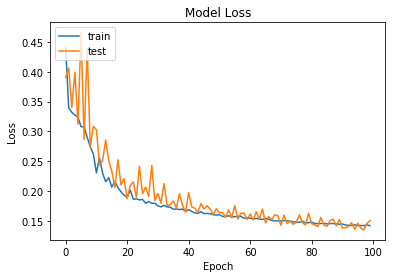

In [22]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

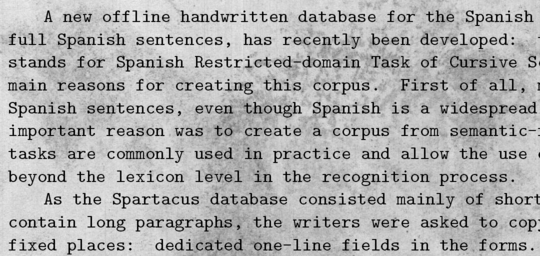

In [26]:
img = np.array((test_data[0] * 255), dtype=np.uint8)
Image.fromarray(img)

In [29]:
def predict_transform(img, model):
    img = img.reshape(256, 540, 1)
    img_clean = model.predict(np.array([img]))[0]
    reshaped_img = img_clean.reshape(256, 540)
    image_array = np.array((reshaped_img * 255), dtype=np.uint8)
    return Image.fromarray(image_array)

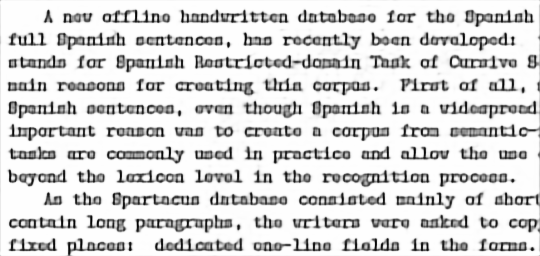

In [31]:
cleaned_img = predict_transform(test_data[0], model)
cleaned_img

The model is cleaning the noises from the image, but the characters in the document are blurry. Let's try a model with less layers to denoise the images.

In [32]:
#Layer 1
model = Sequential()
model.add(Conv2D(64, 3, activation='relu', padding='same', input_shape=input_shape))
model.add(MaxPooling2D(2))
model.add(Dropout(0.4))

#Bottleneck

#Layer 1 Upsizing
model.add(UpSampling2D(2))
model.add(Conv2DTranspose(64, 3, activation='relu', padding='same'))
model.add(Conv2DTranspose(1, 3, activation='sigmoid', padding='same'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 256, 540, 64)      640       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 270, 64)      0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 128, 270, 64)      0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 256, 540, 64)      0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 256, 540, 64)      36928     
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 256, 540, 1)       577       
Total params: 38,145
Trainable params: 38,145
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.compile(optimizer='adadelta', loss='binary_crossentropy')
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
early_stop = EarlyStopping(monitor='val_acc', patience=5, mode='max') 
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [34]:
hist2 = model.fit(
            x_train, y_train, 
            epochs=100,
            batch_size=16,
            shuffle=True,
            validation_data=(x_test, y_test), 
            verbose=1,
            callbacks=[tensorboard, early_stop, checkpoint]
)

Train on 129 samples, validate on 15 samples
Epoch 1/100
129/129 [==============================] - 4s 29ms/step - loss: 0.5617 - val_loss: 0.3620


/opt/anaconda/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:493: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/opt/anaconda/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:402: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


Epoch 2/100
129/129 [==============================] - 3s 23ms/step - loss: 0.3282 - val_loss: 0.3035
Epoch 3/100
129/129 [==============================] - 3s 23ms/step - loss: 0.2980 - val_loss: 0.2766
Epoch 4/100
129/129 [==============================] - 3s 23ms/step - loss: 0.2699 - val_loss: 0.2443
Epoch 5/100
129/129 [==============================] - 3s 23ms/step - loss: 0.2431 - val_loss: 0.2174
Epoch 6/100
129/129 [==============================] - 3s 23ms/step - loss: 0.2173 - val_loss: 0.1878
Epoch 7/100
129/129 [==============================] - 3s 23ms/step - loss: 0.1966 - val_loss: 0.1777
Epoch 8/100
129/129 [==============================] - 3s 23ms/step - loss: 0.1871 - val_loss: 0.1640
Epoch 9/100
129/129 [==============================] - 3s 23ms/step - loss: 0.1727 - val_loss: 0.1651
Epoch 10/100
129/129 [==============================] - 3s 23ms/step - loss: 0.1711 - val_loss: 0.1561
Epoch 11/100
129/129 [==============================] - 3s 23ms/step - loss: 0.16

129/129 [==============================] - 3s 23ms/step - loss: 0.1190 - val_loss: 0.1137
Epoch 82/100
129/129 [==============================] - 3s 23ms/step - loss: 0.1190 - val_loss: 0.1111
Epoch 83/100
129/129 [==============================] - 3s 23ms/step - loss: 0.1186 - val_loss: 0.1150
Epoch 84/100
129/129 [==============================] - 3s 23ms/step - loss: 0.1188 - val_loss: 0.1109
Epoch 85/100
129/129 [==============================] - 3s 23ms/step - loss: 0.1184 - val_loss: 0.1107
Epoch 86/100
129/129 [==============================] - 3s 23ms/step - loss: 0.1189 - val_loss: 0.1106
Epoch 87/100
129/129 [==============================] - 3s 23ms/step - loss: 0.1185 - val_loss: 0.1146
Epoch 88/100
129/129 [==============================] - 3s 23ms/step - loss: 0.1184 - val_loss: 0.1149
Epoch 89/100
129/129 [==============================] - 3s 23ms/step - loss: 0.1181 - val_loss: 0.1104
Epoch 90/100
129/129 [==============================] - 3s 23ms/step - loss: 0.1180 - 

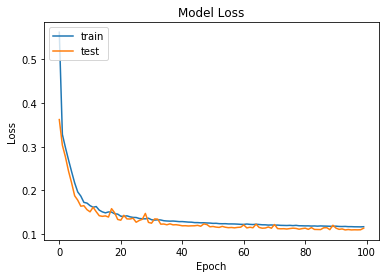

In [35]:
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Loss has reduced by 3.5% and the validation loss looks much smoother when compared to the first model. Next step is to check how this helps the look of some test images.

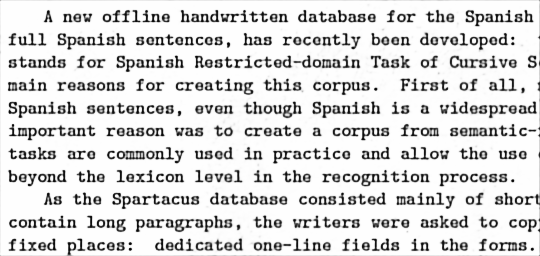

In [36]:
cleaned_img = predict_transform(test_data[0], model)
cleaned_img

# This looks much cleaner now!!! This can be easily fed into an OCR process.

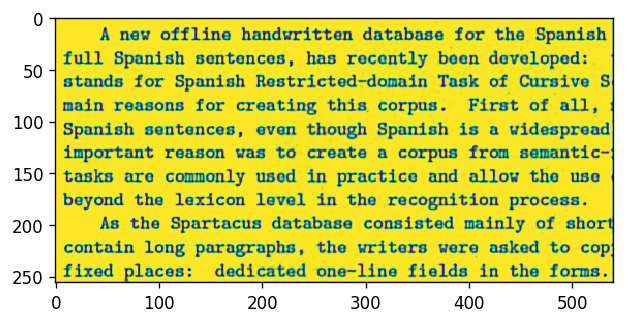

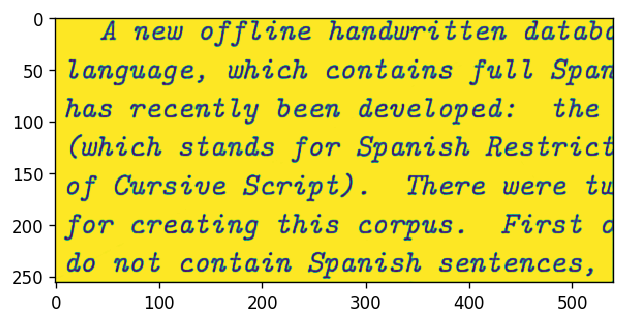

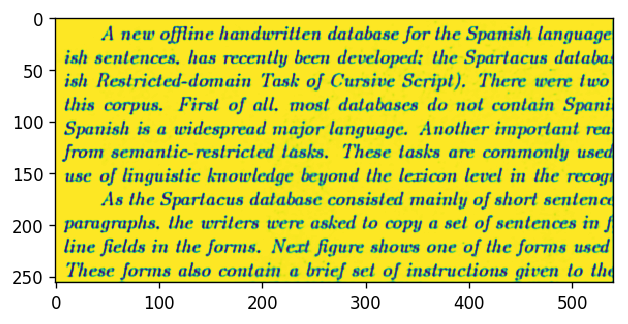

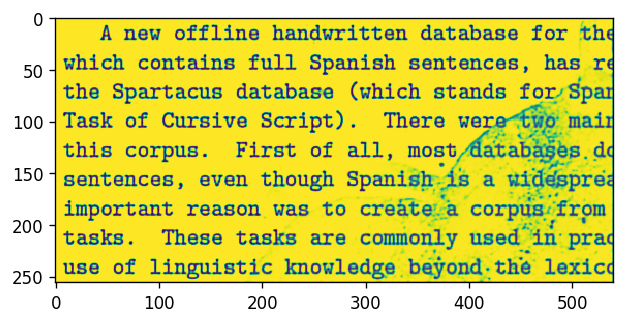

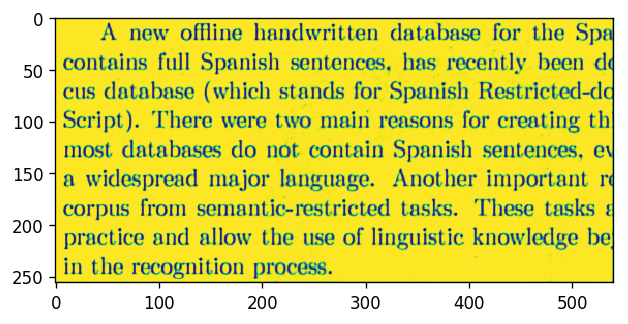

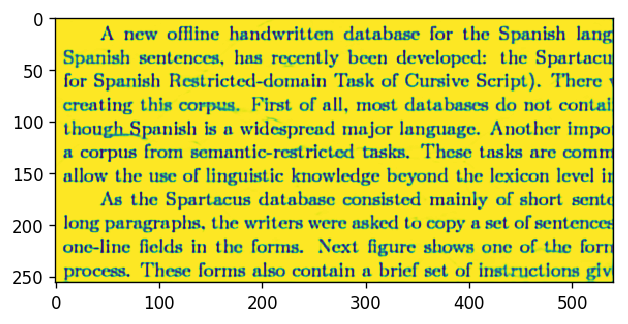

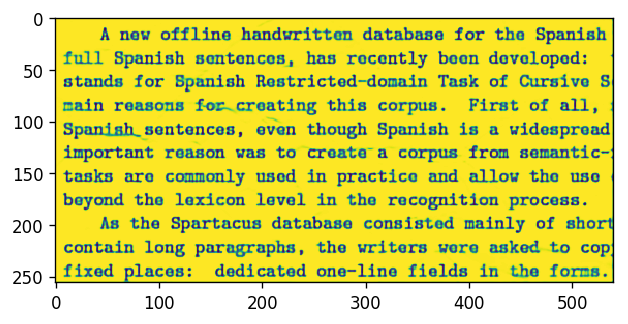

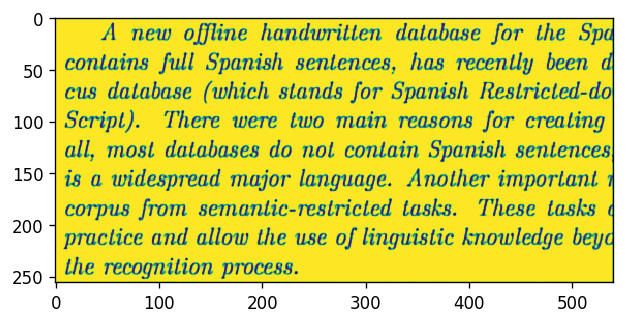

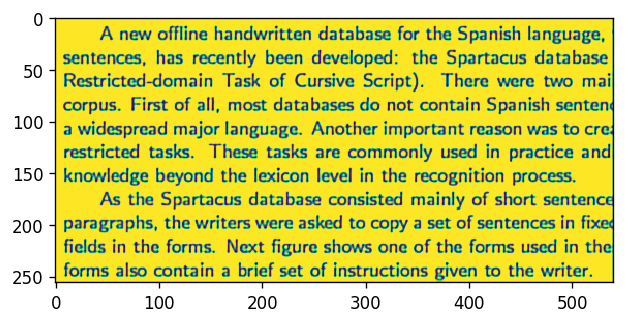

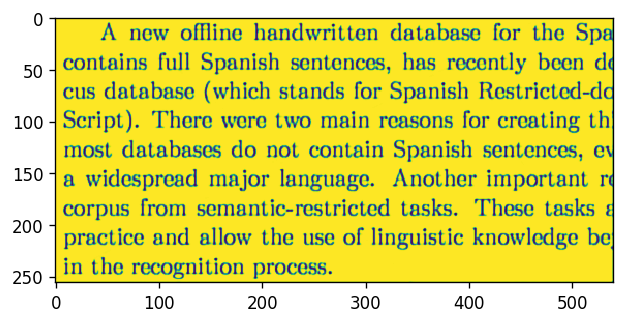

In [48]:
for i in range(10):
    cleaned_img = predict_transform(test_data[i], model)
    plt.figure(figsize=(6, 4), dpi=120, facecolor='w', edgecolor='k')
    plt.imshow(cleaned_img)

Overall the images look much cleaner. There are probably some more hyperparameter changes to make to improve further. The image at index 3 has some more noise to clean up, but overall, the model reduces the noise and maintains the clarity of the fonts.  